In [16]:
# %cd ..
# %ls
# %cd 'D:\\omscs_dl\\group_project\\CS7643_final_project"
# %cd src
%ls


 Volume in drive D is Data Disk
 Volume Serial Number is D0F3-3355

 Directory of d:\omscs_dl\group_project\CS7643_final_project\src

04/26/2023  02:01 PM    <DIR>          .
04/26/2023  02:01 PM    <DIR>          ..
04/24/2023  01:51 PM    <DIR>          .vscode
04/26/2023  02:32 PM            13,687 flop_last_possible_lc_epoch_loss.png
04/27/2023  12:20 PM    <DIR>          holdup
04/24/2023  02:15 PM       587,103,375 last_action - Copy.pickle
04/25/2023  12:47 PM     1,758,807,551 last_action.pickle
04/24/2023  02:15 PM       587,103,375 last_action.pickle_
04/24/2023  02:08 PM       480,631,569 last_possible - Copy.pickle
04/25/2023  12:24 PM     1,374,222,055 last_possible.pickle
04/24/2023  02:08 PM       480,631,569 last_possible.pickle_
04/25/2023  02:45 PM       782,047,631 last_possible_2.pickle
04/26/2023  02:12 PM            20,207 preflop_last_possible_lc_epoch_loss.png
04/26/2023  02:06 PM            22,551 river_last_possible_lc_epoch_loss.png
04/26/2023  02:07 PM      

In [204]:
#!python src/holdup/datapickler.py

# Notebook consists of two parts
# 1) Model Tuning

# 2) Generating dictionaries used for visualization

## Run code below for functions

In [87]:
import os
os.environ["NUMEXPR_MAX_THREADS"] = "64"
from holdup.the_model.autoencoder import Autoencoder
import numpy as np
# import pandas as pd
import torch
from torch import nn
import torch.optim as optim
# from sklearn.model_selection import train_test_split
import random
import os
from holdup.parser.replayable_hand import ReplayableHand, Streets
import functools
from typing import Tuple, List
import matplotlib.pyplot as plt
from holdup.the_model.get_datasets import *
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle


In [20]:

preflop = "preflop"
flop = "flop"
turn = "turn"
river = "river"

def get_stage(dataset, stage):
    if stage == preflop:
        return dataset[0]
    if stage == flop:
        return dataset[1]
    if stage == turn:
        return dataset[2]
    if stage == river:
        return dataset[3]

def flatten_streets(dataset):
    streets = [[], [], [], []]
    for logfile in dataset:
        for index, street in enumerate(logfile):
            streets[index] = streets[index] + street
    return streets


def get_data(dataset, stage):
    flattened_data = flatten_streets(dataset)
    stage_data = get_stage(flattened_data, stage)
    return [(x[0], x[1][1]) for x in stage_data]


with open('last_possible.pickle_', 'rb') as last_possible_pickle:
    last_possible_dataset = pickle.load(last_possible_pickle)

preflop_data = get_data(last_possible_dataset, "preflop")
flop_data = get_data(last_possible_dataset, "flop")
turn_data = get_data(last_possible_dataset, "turn")
river_data = get_data(last_possible_dataset, "river")

def separate_train_test(street_data):
    n_train = int(len(street_data)*0.6)
    train_set = street_data[:n_train]
    test_set = street_data[n_train:]
    return train_set,test_set

train_preflop, test_preflop =separate_train_test(preflop_data)
print("preflop_train_data_size: {}".format(len(train_preflop)))
print("preflop_test_data_size: {}".format(len(test_preflop)))

train_flop, test_flop=separate_train_test(flop_data)
print("flop_train_data_size: {}".format(len(train_flop)))
print("flop_test_data_size: {}".format(len(test_flop)))

train_turn, test_turn=separate_train_test(turn_data)
print("turn_train_data_size: {}".format(len(train_turn)))
print("turn_test_data_size: {}".format(len(test_turn)))

train_river, test_river=separate_train_test(river_data)
print("river_train_data_size: {}".format(len(train_river)))
print("river_test_data_size: {}".format(len(test_river)))





preflop_train_data_size: 30650
preflop_test_data_size: 20434
flop_train_data_size: 23450
flop_test_data_size: 15634
turn_train_data_size: 18447
turn_test_data_size: 12298
river_train_data_size: 16371
river_test_data_size: 10915


In [88]:
# Set the device to use CUDA if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"#torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an instance of the autoencoder
# model = Autoencoder(num_hidden_nodes).to(device)

def train2(learning_rate, model, train_loader, num_epochs, wd, pftr='stage_name'):
    criterion = nn.CrossEntropyLoss() #changed to cross entropy loss for classification based tasks (semi-supervised)
    optimizer = optim.Adam(model.parameters(),lr=learning_rate, weight_decay=wd)
    train_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for data in train_loader:
            inputs, labels = data
            inputs = inputs.float()
            optimizer.zero_grad()
            batch_size, _, _ = inputs.size()
            inputs = inputs.view(batch_size, -1)
            outputs = model(inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)


    
def quick_test2(model,test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs = inputs.float()
            batch_size, _, _ = inputs.size()
            inputs = inputs.view(batch_size, -1)
            outputs = model(inputs.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
    return round((correct/total)*100, 2)


def train_and_quick_test(lr, num_hidden_nodes, num_epochs, weight_decay,train_data,test_data, pftr):
    # Define the model
    model = Autoencoder(num_hidden_nodes).to(device)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=20, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=20, shuffle=False)
    train2(lr, model, train_loader, num_epochs, weight_decay,pftr)
    # Test the model
    quick_test(model,test_loader)
    

###

def tune_model(learning_rate, weight_decay, num_epochs, train, test, pftr, hidden_nodes, batch_size):
        lr = {}
        for i in range(len(learning_rate)):
            lr[str(learning_rate[i])] = []
            for j in range(len(weight_decay)):
                model = Autoencoder(hidden_nodes).to(device)
                train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
                test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)
                train2(learning_rate[i], model, train_loader, num_epochs, weight_decay[j],pftr)
                result = quick_test2(model,test_loader)
                lr[str(learning_rate[i])].append(result)
        return lr
    
def get_nodes_dict(num_experiments, max_nodes, learning_rate, weight_decay, num_epochs, train, test, pftr, batch_size):
        nd = {}
        for i in range(10, max_nodes+10, 10):
            torch.manual_seed(42)
            np.random.seed(42)
            nd[str(i)] = []
            for j in range(num_experiments):
                print(f"Starting {pftr} run {j} of {num_experiments} for hidden nodes {i}")
                model = Autoencoder(i).to(device)
                train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
                test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)
                train2(learning_rate, model, train_loader, num_epochs, weight_decay,pftr)
                result = quick_test2(model,test_loader)
                nd[str(i)].append(result)
            nd[str(i)] = tuple(nd[str(i)])
            print(nd[str(i)],"\n")
        return nd
    

def get_epochs_dict(num_experiments, nodes, learning_rate, weight_decay, max_epochs, train, test, pftr, batch_size):
        nd = {}
        for i in range(10, max_epochs+10, 10):
            nd[str(i)] = []
            torch.manual_seed(42)
            np.random.seed(42)
            for j in range(num_experiments):
                print(f"Starting {pftr} run {j} of {num_experiments} for training epochs {i}")
                model = Autoencoder(nodes).to(device)
                train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
                test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)
                train2(learning_rate, model, train_loader, i, weight_decay,pftr)
                result = quick_test2(model,test_loader)
                nd[str(i)].append(result)
            nd[str(i)] = tuple(nd[str(i)])
            print(nd[str(i)],"\n")
        return nd

# 1) Tuning the model

## Best Model Parameters: 

### Learning Rate: .01 
### Weight Decay: 0 (as it decreases it improves test accuracy)
### Batch Size: 20 (Using a batch size of 20 as default as batch size doesn't have significant impact on model performance)

## Code below is used to see the test accuracy obtained by using different learning rates with different weight decays. It can be seen that using a learning rate of .01 gave the best performance out of all of the models and that by decreasing weight decay the model works better and for that reason we opted to using a weight decay of zero.

In [36]:
lr = [.0001, .001, .01, .1]
wd = [0, .0001, .1]

pre_flop = tune_model(lr, wd, 20, train_preflop, test_preflop, pftr='preflop_last_possible', hidden_nodes=20, batch_size=20)


In [37]:
pre_flop

print("PRE FLOP")
for key, value in pre_flop.items():
    print("learning rate: {}".format(key))
    for j in range(len(value)):
        print("     weight decay: {}".format(wd[j]), "accuracy: {}".format(value[j]))

PRE FLOP
learning rate: 0.0001
     weight decay: 0 accuracy: 80.04
     weight decay: 0.0001 accuracy: 79.88
     weight decay: 0.1 accuracy: 46.97
learning rate: 0.001
     weight decay: 0 accuracy: 81.3
     weight decay: 0.0001 accuracy: 81.26
     weight decay: 0.1 accuracy: 46.97
learning rate: 0.01
     weight decay: 0 accuracy: 83.35
     weight decay: 0.0001 accuracy: 80.67
     weight decay: 0.1 accuracy: 46.97
learning rate: 0.1
     weight decay: 0 accuracy: 80.58
     weight decay: 0.0001 accuracy: 78.76
     weight decay: 0.1 accuracy: 51.77


In [253]:
lr = [.0001, .001, .01, .1]
wd = [0, .0001, .1]

flop = tune_model(lr, wd, 20, train_flop, test_flop, pftr='flop_last_possible', hidden_nodes=20, batch_size=20)

In [254]:
print("FLOP")
for key, value in flop.items():
    print("learning rate: {}".format(key))
    for j in range(len(value)):
        print("     weight decay: {}".format(wd[j]), "accuracy: {}".format(value[j]))

FLOP
learning rate: 0.0001
     weight decay: 0 accuracy: 81.83
     weight decay: 0.0001 accuracy: 82.05
     weight decay: 0.1 accuracy: 56.77
learning rate: 0.001
     weight decay: 0 accuracy: 83.8
     weight decay: 0.0001 accuracy: 83.16
     weight decay: 0.1 accuracy: 56.77
learning rate: 0.01
     weight decay: 0 accuracy: 85.93
     weight decay: 0.0001 accuracy: 83.91
     weight decay: 0.1 accuracy: 56.77
learning rate: 0.1
     weight decay: 0 accuracy: 83.19
     weight decay: 0.0001 accuracy: 77.2
     weight decay: 0.1 accuracy: 56.77


In [255]:
lr = [.0001, .001, .01, .1]
wd = [0, .0001, .1]

turn = tune_model(lr, wd, 40, train_turn, test_turn, pftr='turn_last_possible', hidden_nodes=40, batch_size=20)

In [256]:
print("TURN")
for key, value in turn.items():
    print("learning rate: {}".format(key))
    for j in range(len(value)):
        print("     weight decay: {}".format(wd[j]), "accuracy: {}".format(value[j]))

TURN
learning rate: 0.0001
     weight decay: 0 accuracy: 90.36
     weight decay: 0.0001 accuracy: 90.45
     weight decay: 0.1 accuracy: 68.31
learning rate: 0.001
     weight decay: 0 accuracy: 91.14
     weight decay: 0.0001 accuracy: 90.61
     weight decay: 0.1 accuracy: 68.31
learning rate: 0.01
     weight decay: 0 accuracy: 91.39
     weight decay: 0.0001 accuracy: 90.5
     weight decay: 0.1 accuracy: 68.31
learning rate: 0.1
     weight decay: 0 accuracy: 89.57
     weight decay: 0.0001 accuracy: 87.92
     weight decay: 0.1 accuracy: 68.31


In [257]:
lr = [.0001, .001, .01, .1]
wd = [0, .0001, .1]

river = tune_model(lr, wd, 40, train_river, test_river, pftr='river_last_possible', hidden_nodes=40, batch_size=20)

In [258]:
print("RIVER")
for key, value in river.items():
    print("learning rate: {}".format(key))
    for j in range(len(value)):
        print("     weight decay: {}".format(wd[j]), "accuracy: {}".format(value[j]))

RIVER
learning rate: 0.0001
     weight decay: 0 accuracy: 87.36
     weight decay: 0.0001 accuracy: 87.35
     weight decay: 0.1 accuracy: 59.06
learning rate: 0.001
     weight decay: 0 accuracy: 89.33
     weight decay: 0.0001 accuracy: 89.4
     weight decay: 0.1 accuracy: 59.06
learning rate: 0.01
     weight decay: 0 accuracy: 89.68
     weight decay: 0.0001 accuracy: 88.52
     weight decay: 0.1 accuracy: 59.06
learning rate: 0.1
     weight decay: 0 accuracy: 87.66
     weight decay: 0.0001 accuracy: 85.32
     weight decay: 0.1 accuracy: 59.06


## Code Below is used to demonstrate how changing the batch size does not make significant change to improving the test accuracy of the model


In [215]:
lr = [.01]
wd = [0]
b_s = [8,16,32,64,128,256,512,1024]

ls = []

for z in range(len(b_s)):
    pre_flop = tune_model(lr, wd, 20, train_preflop, test_preflop, pftr='preflop_last_possible', hidden_nodes=20, batch_size=b_s[z])
    ls.append(pre_flop)

print("PRE FLOP")
print("Using learning rate of {} and weight decay of {}:".format(lr[0], wd[0]))
for i in range(len(ls)):
    for key, value in ls[i].items():
        print("     When using batch size of {}, accuracy is {}".format(b_s[i], value[0]))



PRE FLOP
Using learning rate of 0.01 and weight decay of 0:
     When using batch size of 8, accuracy is 83
     When using batch size of 16, accuracy is 83
     When using batch size of 32, accuracy is 83
     When using batch size of 64, accuracy is 83
     When using batch size of 128, accuracy is 83
     When using batch size of 256, accuracy is 83
     When using batch size of 512, accuracy is 82
     When using batch size of 1024, accuracy is 81


In [259]:
lr = [.01]
wd = [0]
b_s = [8,16,32,64,128,256,512,1024]

ls = []

for z in range(len(b_s)):
    flop = tune_model(lr, wd, 20, train_flop, test_flop, pftr='flop_last_possible', hidden_nodes=20, batch_size=b_s[z])
    ls.append(flop)

print("FLOP")
print("Using learning rate of {} and weight decay of {}:".format(lr[0], wd[0]))
for i in range(len(ls)):
    for key, value in ls[i].items():
        print("     When using batch size of {}, accuracy is {}".format(b_s[i], value[0]))


FLOP
Using learning rate of 0.01 and weight decay of 0:
     When using batch size of 8, accuracy is 85.45
     When using batch size of 16, accuracy is 85.75
     When using batch size of 32, accuracy is 86.0
     When using batch size of 64, accuracy is 85.81
     When using batch size of 128, accuracy is 85.54
     When using batch size of 256, accuracy is 85.31
     When using batch size of 512, accuracy is 84.4
     When using batch size of 1024, accuracy is 83.57


In [260]:
lr = [.01]
wd = [0]
b_s = [8,16,32,64,128,256,512,1024]

ls = []

for z in range(len(b_s)):
    turn = tune_model(lr, wd, 40, train_turn, test_turn, pftr='turn_last_possible', hidden_nodes=40, batch_size=b_s[z])
    ls.append(turn)
    
print("TURN")
print("Using learning rate of {} and weight decay of {}:".format(lr[0], wd[0]))
for i in range(len(ls)):
    for key, value in ls[i].items():
        print("     When using batch size of {}, accuracy is {}".format(b_s[i], value[0]))


TURN
Using learning rate of 0.01 and weight decay of 0:
     When using batch size of 8, accuracy is 91.67
     When using batch size of 16, accuracy is 91.38
     When using batch size of 32, accuracy is 91.76
     When using batch size of 64, accuracy is 91.63
     When using batch size of 128, accuracy is 91.67
     When using batch size of 256, accuracy is 91.8
     When using batch size of 512, accuracy is 91.46
     When using batch size of 1024, accuracy is 90.71


In [261]:
lr = [.01]
wd = [0]
b_s = [8,16,32,64,128,256,512,1024]

ls = []

for z in range(len(b_s)):
    river = tune_model(lr, wd, 40, train_river, test_river, pftr='river_last_possible', hidden_nodes=40, batch_size=b_s[z])
    ls.append(river)
    
print("RIVER")
print("Using learning rate of {} and weight decay of {}:".format(lr[0], wd[0]))
for i in range(len(ls)):
    for key, value in ls[i].items():
        print("     When using batch size of {}, accuracy is {}".format(b_s[i], value[0]))


RIVER
Using learning rate of 0.01 and weight decay of 0:
     When using batch size of 8, accuracy is 89.57
     When using batch size of 16, accuracy is 89.44
     When using batch size of 32, accuracy is 89.9
     When using batch size of 64, accuracy is 89.8
     When using batch size of 128, accuracy is 89.74
     When using batch size of 256, accuracy is 89.44
     When using batch size of 512, accuracy is 89.7
     When using batch size of 1024, accuracy is 89.62


# 2) Generating visualization dictionaries - Run all code lines below including the code to pickle the dictionaries

In [48]:
flop_nd = get_nodes_dict(10, 100, .01, 0, 20, train_flop, test_flop, pftr='flop_last_possible', batch_size=20)

Starting flop_last_possible run 0 of 10 for hidden nodes 10
Starting flop_last_possible run 1 of 10 for hidden nodes 10
Starting flop_last_possible run 2 of 10 for hidden nodes 10
Starting flop_last_possible run 3 of 10 for hidden nodes 10
Starting flop_last_possible run 4 of 10 for hidden nodes 10
Starting flop_last_possible run 5 of 10 for hidden nodes 10
Starting flop_last_possible run 6 of 10 for hidden nodes 10
Starting flop_last_possible run 7 of 10 for hidden nodes 10
Starting flop_last_possible run 8 of 10 for hidden nodes 10
Starting flop_last_possible run 9 of 10 for hidden nodes 10
(85.15, 84.88, 84.49, 85.15, 84.62, 85.13, 84.23, 84.96, 85.08, 85.19) 

Starting flop_last_possible run 0 of 10 for hidden nodes 20
Starting flop_last_possible run 1 of 10 for hidden nodes 20
Starting flop_last_possible run 2 of 10 for hidden nodes 20
Starting flop_last_possible run 3 of 10 for hidden nodes 20
Starting flop_last_possible run 4 of 10 for hidden nodes 20
Starting flop_last_possible

In [49]:
flop_nd

{'10': (85.15, 84.88, 84.49, 85.15, 84.62, 85.13, 84.23, 84.96, 85.08, 85.19),
 '20': (85.79, 85.8, 85.85, 86.2, 85.47, 85.69, 85.83, 85.28, 85.4, 85.88),
 '30': (86.16, 86.41, 85.72, 85.79, 86.0, 86.11, 86.06, 86.42, 85.78, 85.67),
 '40': (86.13, 86.2, 86.21, 86.04, 85.47, 85.79, 85.84, 86.27, 85.79, 86.64),
 '50': (86.27, 86.32, 86.18, 86.52, 86.26, 86.32, 86.44, 85.93, 86.05, 86.2),
 '60': (86.32, 85.88, 86.3, 86.34, 86.49, 86.17, 86.47, 86.28, 86.28, 86.4),
 '70': (86.59, 86.6, 86.11, 86.68, 86.52, 86.35, 86.44, 86.38, 86.04, 85.88),
 '80': (86.75, 86.65, 86.21, 86.29, 86.32, 86.4, 86.02, 86.35, 86.37, 86.53),
 '90': (86.47, 86.84, 86.54, 86.53, 86.31, 86.41, 86.54, 86.77, 86.16, 86.46),
 '100': (86.28, 86.75, 86.77, 86.38, 86.48, 86.27, 85.72, 86.43, 86.32, 86.73)}

In [79]:
turn_nd = get_nodes_dict(10, 100, .01, 0, 40, train_turn, test_turn, pftr='turn_last_possible', batch_size=20)

Starting turn_last_possible run 0 of 10 for hidden nodes 10
Starting turn_last_possible run 1 of 10 for hidden nodes 10
Starting turn_last_possible run 2 of 10 for hidden nodes 10
Starting turn_last_possible run 3 of 10 for hidden nodes 10
Starting turn_last_possible run 4 of 10 for hidden nodes 10
Starting turn_last_possible run 5 of 10 for hidden nodes 10
Starting turn_last_possible run 6 of 10 for hidden nodes 10
Starting turn_last_possible run 7 of 10 for hidden nodes 10
Starting turn_last_possible run 8 of 10 for hidden nodes 10
Starting turn_last_possible run 9 of 10 for hidden nodes 10
(91.01, 90.86, 91.23, 90.74, 91.19, 91.57, 91.19, 90.84, 91.74, 91.38) 

Starting turn_last_possible run 0 of 10 for hidden nodes 20
Starting turn_last_possible run 1 of 10 for hidden nodes 20
Starting turn_last_possible run 2 of 10 for hidden nodes 20
Starting turn_last_possible run 3 of 10 for hidden nodes 20
Starting turn_last_possible run 4 of 10 for hidden nodes 20
Starting turn_last_possible

In [80]:
turn_nd
with open("turn_nd.pickle", "wb") as f: 
    pickle.dump(turn_nd, f)
    

In [81]:
river_nd = get_nodes_dict(10, 100, .01, 0, 40, train_river, test_river, pftr='river_last_possible', batch_size=20)

Starting river_last_possible run 0 of 10 for hidden nodes 10
Starting river_last_possible run 1 of 10 for hidden nodes 10
Starting river_last_possible run 2 of 10 for hidden nodes 10
Starting river_last_possible run 3 of 10 for hidden nodes 10
Starting river_last_possible run 4 of 10 for hidden nodes 10
Starting river_last_possible run 5 of 10 for hidden nodes 10
Starting river_last_possible run 6 of 10 for hidden nodes 10
Starting river_last_possible run 7 of 10 for hidden nodes 10
Starting river_last_possible run 8 of 10 for hidden nodes 10
Starting river_last_possible run 9 of 10 for hidden nodes 10
(88.9, 89.66, 89.43, 89.58, 89.77, 89.45, 89.47, 88.65, 89.07, 89.36) 

Starting river_last_possible run 0 of 10 for hidden nodes 20
Starting river_last_possible run 1 of 10 for hidden nodes 20
Starting river_last_possible run 2 of 10 for hidden nodes 20
Starting river_last_possible run 3 of 10 for hidden nodes 20
Starting river_last_possible run 4 of 10 for hidden nodes 20
Starting rive

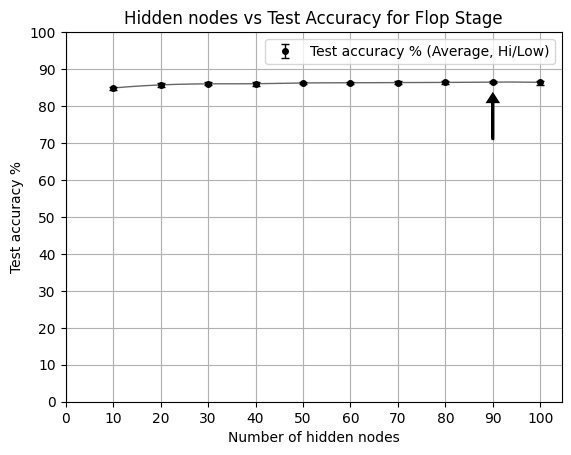

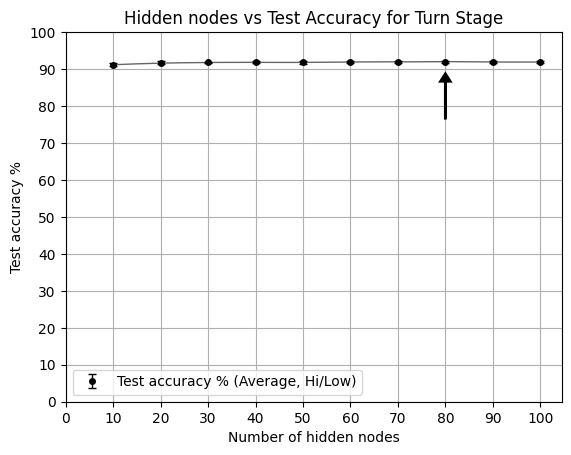

In [82]:
river_nd
with open("river_nd.pickle", "wb") as f: 
    pickle.dump(river_nd, f)
    

In [83]:
flop_ed = get_epochs_dict(10, 20, .01, 0, 100, train_flop, test_flop, pftr='flop_last_possible', batch_size=20)


Starting flop_last_possible run 0 of 10 for training epochs 10
Starting flop_last_possible run 1 of 10 for training epochs 10
Starting flop_last_possible run 2 of 10 for training epochs 10
Starting flop_last_possible run 3 of 10 for training epochs 10
Starting flop_last_possible run 4 of 10 for training epochs 10
Starting flop_last_possible run 5 of 10 for training epochs 10
Starting flop_last_possible run 6 of 10 for training epochs 10
Starting flop_last_possible run 7 of 10 for training epochs 10
Starting flop_last_possible run 8 of 10 for training epochs 10
Starting flop_last_possible run 9 of 10 for training epochs 10
(85.81, 85.78, 85.49, 85.77, 85.86, 85.71, 85.55, 85.4, 85.25, 85.61) 

Starting flop_last_possible run 0 of 10 for training epochs 20
Starting flop_last_possible run 1 of 10 for training epochs 20
Starting flop_last_possible run 2 of 10 for training epochs 20
Starting flop_last_possible run 3 of 10 for training epochs 20
Starting flop_last_possible run 4 of 10 for tr

In [84]:
flop_ed
with open("flop_ed.pickle", "wb") as f: 
    pickle.dump(flop_ed, f)

In [89]:
turn_ed = get_epochs_dict(10, 40, .01, 0, 100, train_turn, test_turn, pftr='turn_last_possible', batch_size=20)

Starting turn_last_possible run 0 of 10 for training epochs 10
Starting turn_last_possible run 1 of 10 for training epochs 10
Starting turn_last_possible run 2 of 10 for training epochs 10
Starting turn_last_possible run 3 of 10 for training epochs 10
Starting turn_last_possible run 4 of 10 for training epochs 10
Starting turn_last_possible run 5 of 10 for training epochs 10
Starting turn_last_possible run 6 of 10 for training epochs 10
Starting turn_last_possible run 7 of 10 for training epochs 10
Starting turn_last_possible run 8 of 10 for training epochs 10
Starting turn_last_possible run 9 of 10 for training epochs 10
(91.57, 91.68, 91.77, 91.13, 91.48, 91.99, 91.74, 91.7, 91.51, 91.18) 

Starting turn_last_possible run 0 of 10 for training epochs 20
Starting turn_last_possible run 1 of 10 for training epochs 20
Starting turn_last_possible run 2 of 10 for training epochs 20
Starting turn_last_possible run 3 of 10 for training epochs 20
Starting turn_last_possible run 4 of 10 for tr

In [90]:
turn_ed
with open("turn_ed.pickle", "wb") as f: 
    pickle.dump(turn_ed, f)

In [92]:
turn_ed

{'10': (91.57, 91.68, 91.77, 91.13, 91.48, 91.99, 91.74, 91.7, 91.51, 91.18),
 '20': (91.54, 91.8, 91.98, 92.12, 91.79, 91.95, 91.89, 91.91, 91.98, 91.85),
 '30': (91.68, 91.98, 91.8, 91.8, 91.69, 92.04, 91.9, 91.95, 91.76, 91.94),
 '40': (91.81, 91.84, 92.11, 91.75, 91.68, 91.93, 91.75, 91.57, 91.81, 91.97),
 '50': (91.62, 91.86, 91.97, 91.95, 91.89, 91.97, 92.07, 91.97, 91.83, 91.77),
 '60': (91.49, 91.72, 91.93, 91.94, 91.9, 91.82, 92.08, 91.7, 91.73, 92.12),
 '70': (91.71, 91.97, 91.85, 92.07, 91.88, 91.8, 91.73, 91.77, 92.15, 91.82),
 '80': (91.63, 91.67, 91.58, 91.57, 91.42, 91.95, 92.02, 92.06, 92.06, 91.95),
 '90': (91.49, 91.69, 91.85, 91.9, 91.9, 91.44, 91.6, 91.87, 91.61, 91.57),
 '100': (91.75, 91.9, 91.5, 91.82, 91.8, 92.01, 91.47, 91.89, 91.94, 91.7)}

In [93]:
river_ed = get_epochs_dict(10, 40, .01, 0, 100, train_river, test_river, pftr='river_last_possible', batch_size=20)

Starting river_last_possible run 0 of 10 for training epochs 10
Starting river_last_possible run 1 of 10 for training epochs 10
Starting river_last_possible run 2 of 10 for training epochs 10
Starting river_last_possible run 3 of 10 for training epochs 10
Starting river_last_possible run 4 of 10 for training epochs 10
Starting river_last_possible run 5 of 10 for training epochs 10
Starting river_last_possible run 6 of 10 for training epochs 10
Starting river_last_possible run 7 of 10 for training epochs 10
Starting river_last_possible run 8 of 10 for training epochs 10
Starting river_last_possible run 9 of 10 for training epochs 10
(89.64, 89.08, 89.75, 89.49, 89.67, 89.76, 90.08, 89.45, 89.49, 89.7) 

Starting river_last_possible run 0 of 10 for training epochs 20
Starting river_last_possible run 1 of 10 for training epochs 20
Starting river_last_possible run 2 of 10 for training epochs 20
Starting river_last_possible run 3 of 10 for training epochs 20
Starting river_last_possible run

In [94]:
river_ed
with open("river_ed.pickle", "wb") as f: 
    pickle.dump(river_ed, f)

## Running the line below will pickle the dictionaries that will be used for the visualization

In [95]:
import pickle

with open("flop_nd.pickle", "wb") as f: 
    pickle.dump(flop_nd, f)
    
with open("turn_nd.pickle", "wb") as f: 
    pickle.dump(turn_nd, f)
    
with open("river_nd.pickle", "wb") as f: 
    pickle.dump(river_nd, f)
    
with open("flop_ed.pickle", "wb") as f: 
    pickle.dump(flop_ed, f)
    
with open("turn_ed.pickle", "wb") as f: 
    pickle.dump(turn_ed, f)
    
with open("river_ed.pickle", "wb") as f: 
    pickle.dump(river_ed, f)